

# Yield Curve Construction

In this case study we use principal component analysis (PCA) to generate the typical movements of a yield curve 

## 1. Problem definition

Empirical studies reveal that more than 99% of the movement of various U.S. treasury bond yields are captured by 3 factors; level, slope and curvature.
Dimensionality reduction breaks down the movement of the yield curve into these 3 factors.


Our goal in this case study is to use dimensionality reduction techniques to generate
the “typical” movements of a yield curve.
The data used for this case study is obtained from FRED. 

FRED is a premier source for financial, economic and alternative datasets. We use the data of 11 tenors
(from 1 month to 30 years) of the treasury curves. The frequency of the data is daily
and the data is available from 1960 onwards



## 2. Loading data

In [16]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from fredapi import Fred

#Import Model Packages 
from sklearn.decomposition import PCA

In [17]:
# Set API key
fred = Fred(api_key='5f1a3e31a187770c52134d92a21ad62a')

# Download treasury data
treasury_df = pd.DataFrame({
    'TRESY1mo': fred.get_series('DGS1MO'),
    'TRESY3mo': fred.get_series('DGS3MO'),
    'TRESY6mo': fred.get_series('DGS6MO'),
    'TRESY1y': fred.get_series('DGS1'),
    'TRESY2y': fred.get_series('DGS2'),
    'TRESY3y': fred.get_series('DGS3'),
    'TRESY5y': fred.get_series('DGS5'),
    'TRESY7y': fred.get_series('DGS7'),
    'TRESY10y': fred.get_series('DGS10'),
    'TRESY20y': fred.get_series('DGS20'),
    'TRESY30y': fred.get_series('DGS30')
})

print(treasury_df.head())
print(f"Data shape: {treasury_df.shape}")

            TRESY1mo  TRESY3mo  TRESY6mo  TRESY1y  TRESY2y  TRESY3y  TRESY5y  \
1962-01-02       NaN       NaN       NaN     3.22      NaN     3.70     3.88   
1962-01-03       NaN       NaN       NaN     3.24      NaN     3.70     3.87   
1962-01-04       NaN       NaN       NaN     3.24      NaN     3.69     3.86   
1962-01-05       NaN       NaN       NaN     3.26      NaN     3.71     3.89   
1962-01-08       NaN       NaN       NaN     3.31      NaN     3.71     3.91   

            TRESY7y  TRESY10y  TRESY20y  TRESY30y  
1962-01-02      NaN      4.06      4.07       NaN  
1962-01-03      NaN      4.03      4.07       NaN  
1962-01-04      NaN      3.99      4.06       NaN  
1962-01-05      NaN      4.02      4.07       NaN  
1962-01-08      NaN      4.03      4.08       NaN  
Data shape: (16709, 11)


In [18]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

## 3. Exploratory data analysis

In [19]:
# peek at data
set_option('display.width', 100)
treasury_df.tail(5)

,TRESY1mo,TRESY3mo,TRESY6mo,TRESY1y,TRESY2y,TRESY3y,TRESY5y,TRESY7y,TRESY10y,TRESY20y,TRESY30y
2026-01-12,3.71,3.67,3.58,3.53,3.54,3.59,3.77,3.97,4.19,4.78,4.83
2026-01-13,3.72,3.67,3.59,3.51,3.53,3.57,3.75,3.95,4.18,4.77,4.83
2026-01-14,3.72,3.67,3.58,3.50,3.51,3.56,3.72,3.92,4.15,4.73,4.79
2026-01-15,3.75,3.68,3.60,3.54,3.56,3.62,3.77,3.96,4.17,4.74,4.79
2026-01-16,3.75,3.67,3.60,3.55,3.59,3.67,3.82,4.02,4.24,4.79,4.83


In [20]:
# types
set_option('display.max_rows', 500)
treasury_df.dtypes

TRESY1mo    float64
TRESY3mo    float64
TRESY6mo    float64
TRESY1y     float64
TRESY2y     float64
TRESY3y     float64
TRESY5y     float64
TRESY7y     float64
TRESY10y    float64
TRESY20y    float64
TRESY30y    float64
dtype: object

In [21]:
# describe data
set_option('display.precision', 3)
treasury_df.describe()

,TRESY1mo,TRESY3mo,TRESY6mo,TRESY1y,TRESY2y,TRESY3y,TRESY5y,TRESY7y,TRESY10y,TRESY20y,TRESY30y
count,6117.000,11093.000,11093.000,15995.000,12403.000,15995.000,15995.000,14125.000,15995.000,14306.000,12225.000
mean,1.667,3.829,3.995,4.883,4.966,5.251,5.495,5.818,5.819,5.857,6.171
std,1.834,3.133,3.235,3.361,3.675,3.256,3.134,3.197,2.941,2.841,2.989
min,0.000,0.000,0.020,0.040,0.090,0.100,0.190,0.360,0.520,0.870,0.990
25%,0.080,0.920,1.020,2.300,1.680,2.840,3.280,3.250,3.880,4.060,3.890
50%,0.980,3.970,4.140,4.920,4.670,5.030,5.250,5.850,5.450,5.240,5.480
75%,2.680,5.600,5.730,6.670,7.140,7.185,7.390,7.790,7.550,7.260,8.070
max,6.020,17.010,17.430,17.310,16.950,16.590,16.270,16.050,15.840,15.780,15.210


Let us look at the movement of the yield curve. 

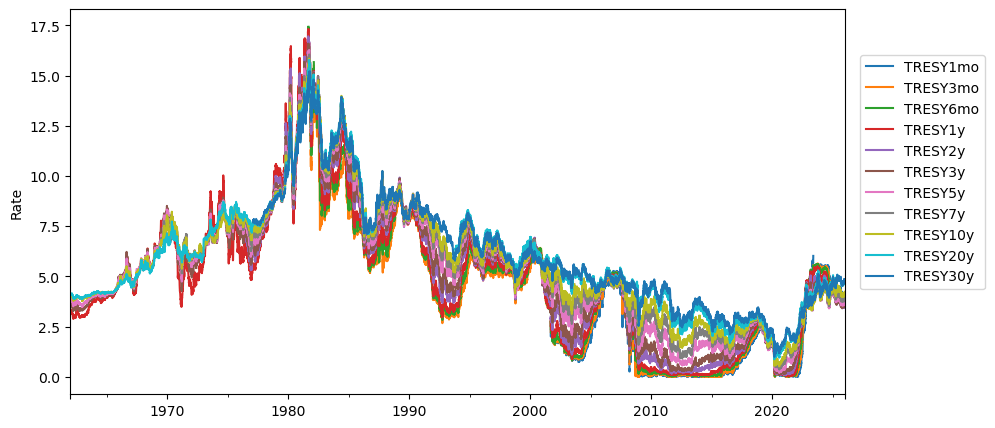

In [22]:
treasury_df.plot(figsize=(10,5))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

In the next step we look at the correlation.

<Axes: title={'center': 'Correlation Matrix'}>

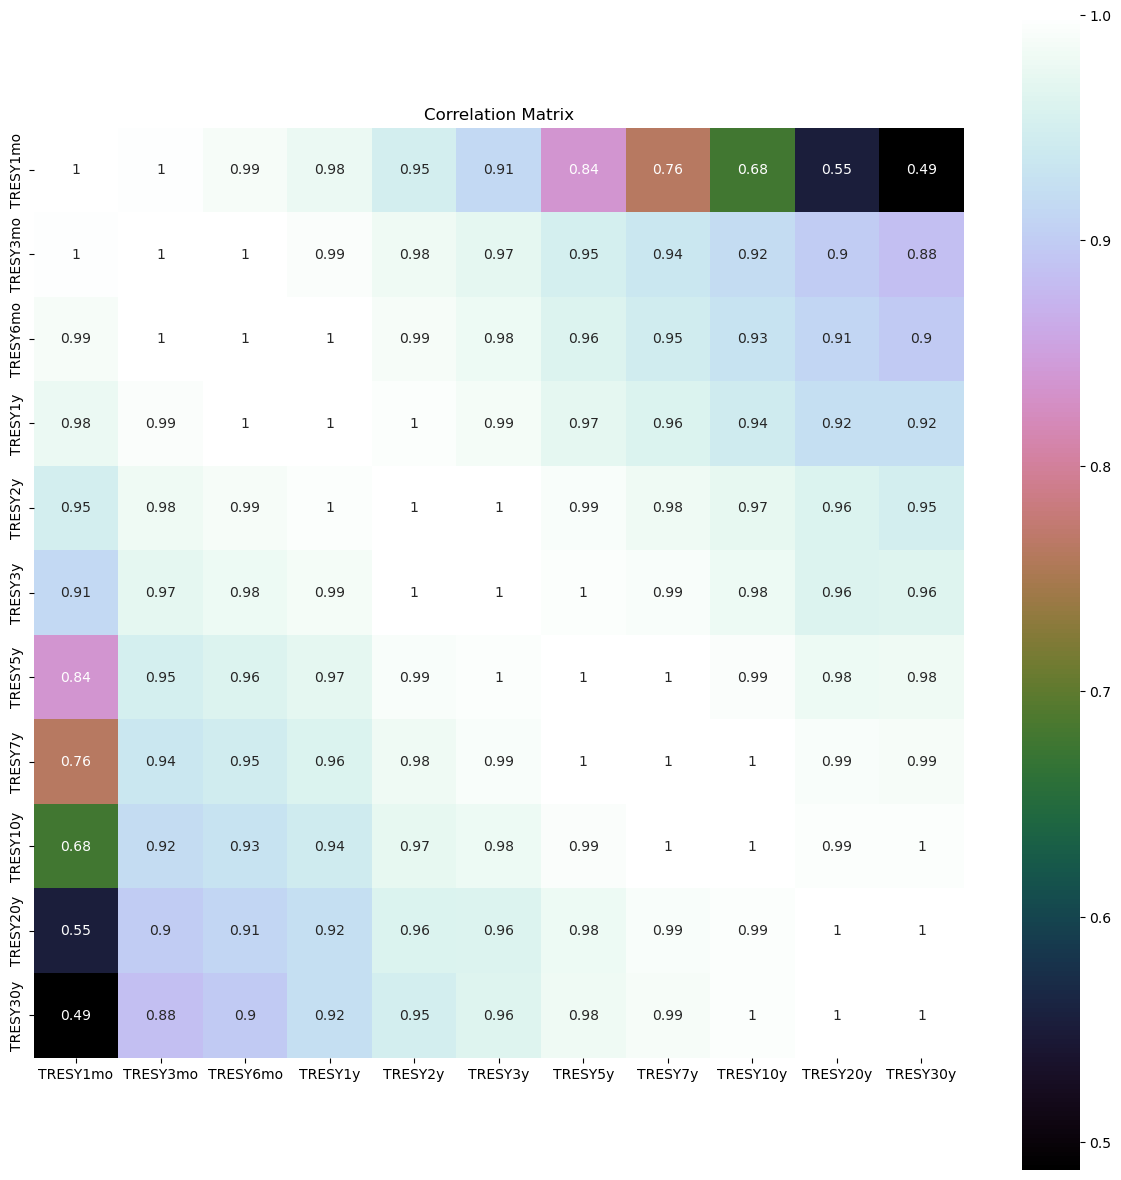

In [23]:
# correlation
correlation = treasury_df.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

As it can be seen by the picture above there is a significant positive correlation between the stocks. 

## 4. Data preparation

We check for the NAs in the data, either drop them or fill them with the mean of the column.

In [24]:
#Checking for any null values and removing the null values'''
print('Null Values =',treasury_df.isnull().values.any())

Null Values = True


Given that there are null values drop the rows contianing the null values.

In [ ]:
# Fill the missing values with the last value available in the dataset. 
treasury_df=treasury_df.fillna(method='ffill')

# Drop the rows containing NA (a lot of rows dropped as no known data at the start)
treasury_df= treasury_df.dropna(axis=0)

# Fill na with 0
#treasury_df.fillna('0')

treasury_df.head(2)

,TRESY1mo,TRESY3mo,TRESY6mo,TRESY1y,TRESY2y,TRESY3y,TRESY5y,TRESY7y,TRESY10y,TRESY20y,TRESY30y
2001-07-31,3.67,3.54,3.47,3.53,3.79,4.06,4.57,4.86,5.07,5.61,5.51
2001-08-01,3.65,3.53,3.47,3.56,3.83,4.09,4.62,4.90,5.11,5.63,5.53


All the variables should be on the same scale before applying PCA, otherwise a feature with large values will dominate the result. We use StandardScaler in sklearn to standardize the dataset’s features onto unit scale (mean = 0 and variance = 1).

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(treasury_df)
rescaledDataset = pd.DataFrame(scaler.fit_transform(treasury_df),columns = treasury_df.columns, index = treasury_df.index)
# summarize transformed data
treasury_df.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(2)

,TRESY1mo,TRESY3mo,TRESY6mo,TRESY1y,TRESY2y,TRESY3y,TRESY5y,TRESY7y,TRESY10y,TRESY20y,TRESY30y
2001-07-31,1.092,0.985,0.904,0.944,1.099,1.246,1.500,1.598,1.623,1.604,1.572
2001-08-01,1.081,0.979,0.904,0.961,1.124,1.266,1.538,1.630,1.657,1.621,1.590


visualising the standardised dataset

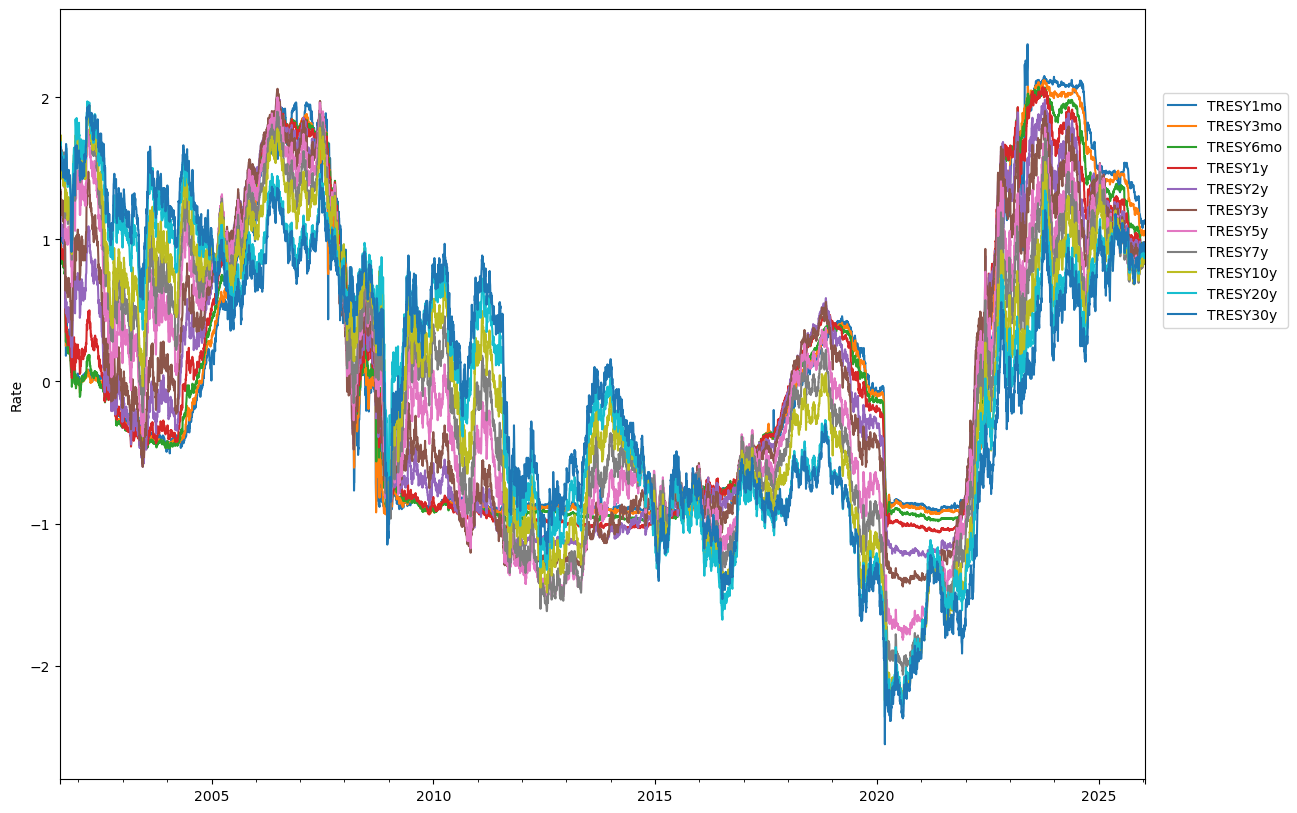

In [27]:
rescaledDataset.plot(figsize=(14,10))
plt.ylabel("Rate")
plt.legend(bbox_to_anchor=(1.01, 0.9), loc=2)
plt.show()

## 5. Evaluate algorithms and models

As the next step We create a function to compute Principle Component Analysis from Sklearn. This function computes an inversed elbow chart that shows the amount of principle components and how many of them explain the variance treshold.

In [28]:
pca = PCA()
PrincipalComponent=pca.fit(rescaledDataset)

,Explained Variance_Top 5
0,84.74%
1,98.67%
2,99.77%
3,99.89%
4,99.94%


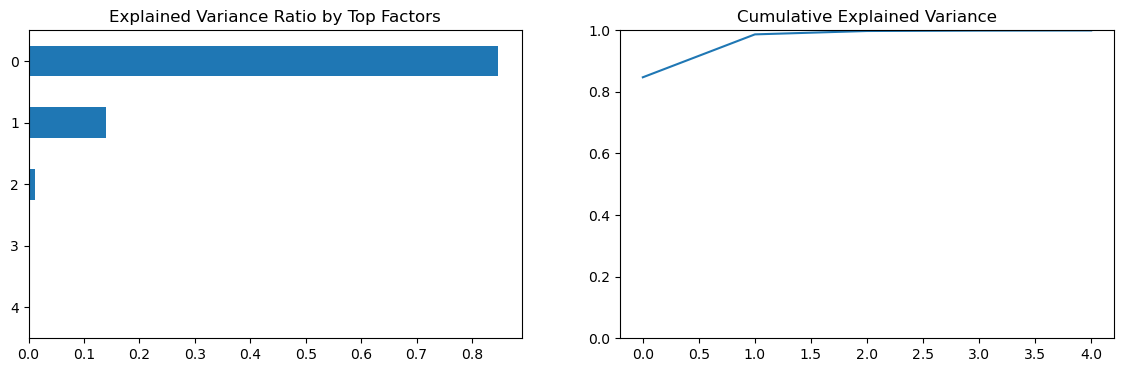

In [29]:
NumEigenvalues=5
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values().plot.barh(title='Explained Variance Ratio by Top Factors',ax=axes[0]);
pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum().plot(ylim=(0,1),ax=axes[1], title='Cumulative Explained Variance');

# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance_Top 5').head(NumEigenvalues).style.format('{:,.2%}'.format)

Indeed, the first principal component accounts for 84.74% of variance, with the second principal component getting 98.67% and the third 99.89%. The first 3 principal components account for, cumulatively, 99.9% of all movements in the data. Hence, in terms of dimensionality reduction, the first 3 principal components are representative of the data.

Intuition behind the principal components:
We first have a function to determine the weights of each principal component. We then
perform the visualization of the principal components.

In [30]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()

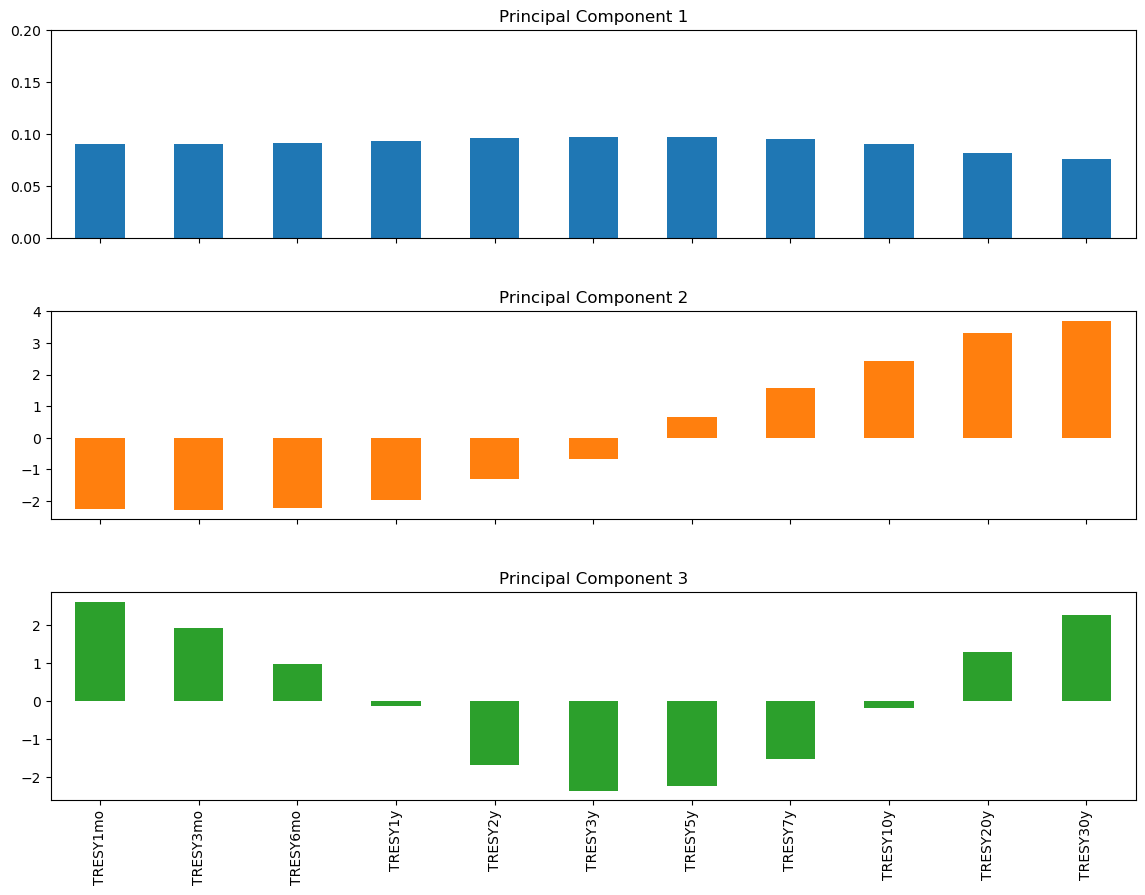

In [32]:
weights = PCWeights()
NumComponents=3    

topPortfolios = pd.DataFrame(weights[:NumComponents], columns=treasury_df.columns)
topPortfolios.index = [f'Principal Component {i}' for i in range(1, NumComponents+1)]

axes = topPortfolios.T.plot.bar(subplots=True, legend=False,figsize=(14,10))
plt.subplots_adjust(hspace=0.35)
axes[0].set_ylim(0, .2);

<Axes: title={'center': 'Principal Component'}>

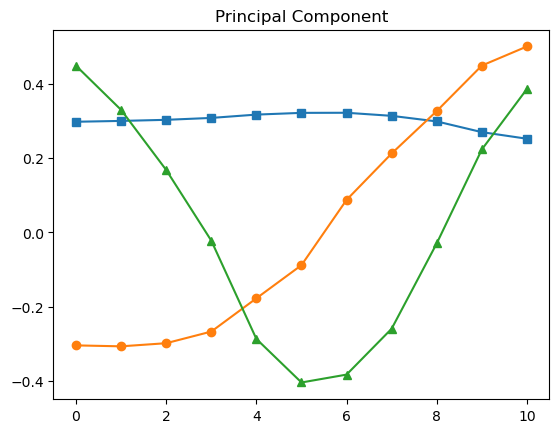

In [33]:
pd.DataFrame(pca.components_[0:3].T).plot(style= ['s-','o-','^-'], \
                            legend=False, title="Principal Component")

## Principal Component Interpretation

**Blue line (PC1 - ~30% variance):** Roughly flat across all maturities - this is the **level shift**. When PC1 increases, all rates move up together proportionally.

**Orange line (PC2):** Starts negative (short-term), crosses zero (mid-term), ends positive (long-term) - this is the **slope/steepening**. When PC2 increases, short rates fall and long rates rise (curve steepens).

**Green line (PC3):** High at short-term, dips negative in the middle (5-7 years), rises at long-term - this is **curvature/butterfly**. When PC3 increases, short and long rates rise while middle rates fall (curve becomes more curved/humped).


Reconstructing the curve using principal components.

In [34]:
pca.transform(rescaledDataset)[:,:2]

array([[ 4.23878773,  1.04887296],
       [ 4.29560017,  1.08106346],
       [ 4.39610312,  1.14027623],
       ...,
       [ 3.06752876, -0.06976523],
       [ 3.13742176, -0.07543591],
       [ 3.22048523, -0.01129263]], shape=(6384, 2))

Using the simple matrix reconstruction, we can generate an approximation/almost exact replica of the initial data.

Mechanically PCA is just a matrix multiplication:

Y=XW,

where Y is your principal components, X is input data, and W is a matrix of coefficients.


The only trick here is that your matrix of coefficients is quite special: you can use it to recover the original matrix.

X=YW′,

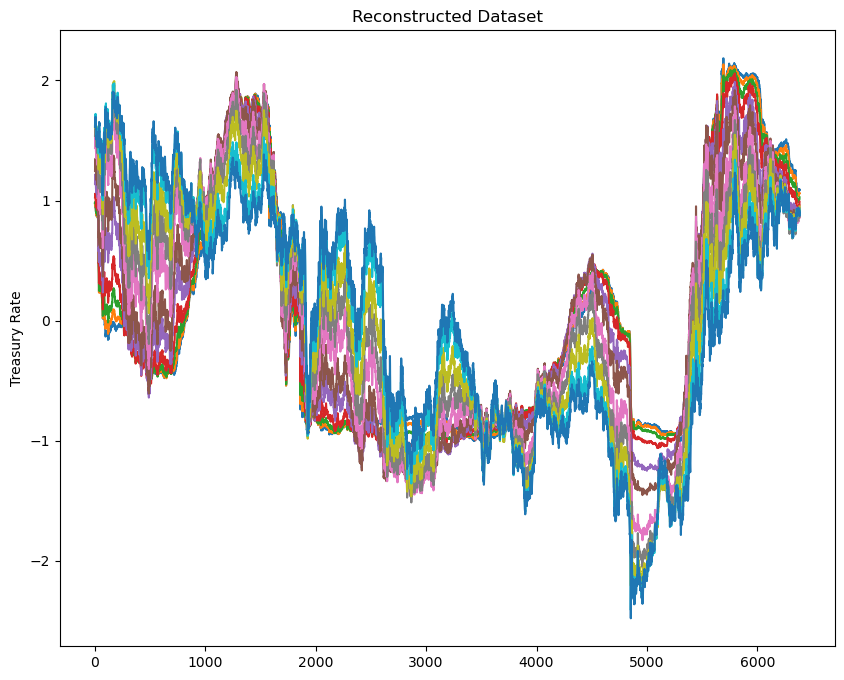

In [36]:
nComp=3
reconst= pd.DataFrame(np.dot(pca.transform(rescaledDataset)[:,:nComp], pca.components_[:nComp,:]),columns=treasury_df.columns)
plt.figure(figsize=(10,8))
plt.plot(reconst)
plt.ylabel("Treasury Rate")
plt.title("Reconstructed Dataset")
plt.show()

__Conclusion__

We demonstrated the efficiency of dimensionality reduction and principal components analysis in reducing the number of dimension and coming up with new intuitive feature.


The first
three principal components explain more than 99.5% of the variation and represent
directional movements, slope movements, and curvature movements respectively.
Overall, by using principal component analysis, analyzing the eigen vectors and
understanding the intuition behind them, we demonstrated how the implementation
of a dimensionality reduction lead to fewer intuitive dimensions in the yield curve.
